In [1]:
import os
import os.path
import gc
import itertools
import numpy as np
import pandas as pd
import scipy.sparse
from tqdm import tqdm

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
import pickle

def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

## Read Data

In [6]:
%%time
DATA_DIR = '../input/open-problems-multimodal'
train_tar = pd.read_hdf(f'{DATA_DIR}/train_cite_targets.h5')
train_tar_cols = train_tar.columns

CPU times: user 222 ms, sys: 104 ms, total: 326 ms
Wall time: 962 ms


In [7]:
train_tar = train_tar.values

In [8]:
%%time
DATA_DIR = '../input/msci-citeseq-mlp-tsvd'
train_inp = load_pickle(f'{DATA_DIR}/train_inp')

CPU times: user 84.5 ms, sys: 411 ms, total: 496 ms
Wall time: 2.01 s


## Assign Folds

In [9]:
donor_info = train_inp[:, -1]

In [10]:
donors = list(set(donor_info))
donor_idx_dict = {donor: [idx for idx in range(len(donor_info))
                          if donor_info[idx] == donor] 
                  for donor in donors}

In [11]:
folds = {donor: {'inp': train_inp[donor_idx_dict[donor], :-1],
                 'tar': train_tar[donor_idx_dict[donor], :]}
         for donor in donors}

In [12]:
# del train_inp, train_tar
# gc.collect()

In [13]:
for donor in donors:
    print(donor, folds[donor]['inp'].shape, folds[donor]['tar'].shape)

13176.0 (22199, 656) (22199, 140)
31800.0 (24803, 656) (24803, 140)
32606.0 (23986, 656) (23986, 140)


## Modeling

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

### Dataset & DataLoader

In [15]:
c1 = [[13176.0, 31800.0], 32606.0]
c2 = [[13176.0, 32606.0], 31800.0]
c3 = [[32606.0, 31800.0], 13176.0]

In [16]:
def set_up_dataloader(c, folds=folds):
    train_folds, val_fold = c
    
    # Train
    train_inp = torch.from_numpy(np.vstack([folds[donor]['inp']
                                            for donor in train_folds]))
    train_tar = torch.from_numpy(np.vstack([folds[donor]['tar']
                                            for donor in train_folds]))
    train_ds = TensorDataset(train_inp, train_tar)
    
    # Val
    val_inp = torch.from_numpy(folds[val_fold]['inp'])
    val_tar = torch.from_numpy(folds[val_fold]['tar'])
    val_ds = TensorDataset(val_inp, val_tar)
    
    # Set up dataloader
    batch_size = 512
    train_loader = DataLoader(train_ds, 
                              batch_size=batch_size, 
                              shuffle=True)
    val_loader = DataLoader(val_ds, 
                            batch_size=batch_size, 
                            shuffle=False)
    
    return train_loader, val_loader

### Define NN

In [17]:
class Net(nn.Module):
    def __init__(self):
        """In the constructor we instantiate two nn.Linear modules and assign them as
        member variables (self).
        """
        super(Net, self).__init__()
#         self.linear1 = nn.Linear(663, 128*2)
        self.linear1 = nn.Linear(656, 128*4)
        self.selu1 = nn.SELU(128*4)
        self.linear2 = nn.Linear(128*4, 128*4)
        self.selu2 = nn.SELU(128*4)
        self.linear3 = nn.Linear(128*4, 128*4)
        self.selu3 = nn.SELU(128*4)
        self.linear4 = nn.Linear(128*4, 140)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.linear1(x)
        x = self.selu1(x)
        x = self.linear2(x)
        x = self.selu2(x)
        x = self.linear3(x)
        x = self.selu3(x)
        x = self.linear4(x)
        return x

### Find LR

In [18]:
def find_lr(model, train_loader, optimizer,
            init_val=1e-8, final_val=10.0, beta=0.98):
    # https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate
    
    num = len(train_loader)
    mult = (final_val / init_val) ** (1 / num)
    lr = init_val
    optimizer.param_groups[0]['lr'] = lr
    
    avg_loss = 0
    best_loss = 0
    batch_num = 0
    smoothed_losses = []
    raw_losses = []
    log_lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch_num+=1
        batch = x.shape[0]
        
        optimizer.zero_grad()
        
        # Prediction
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        loss_cpu = float(loss.detach().numpy())
        
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss_cpu
        smoothed_loss = avg_loss / (1 - beta ** batch_num)
        
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
            
        raw_losses.append(loss_cpu)
        smoothed_losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))
        
        loss.backward()
        optimizer.step()
        
        # Update the lr for the next batch
        lr*=mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, raw_losses, smoothed_losses

In [19]:
def find_lr_for_one_comb(c, folds=folds):
    # Set up dataloader
    train_loader, val_loader = set_up_dataloader(c, folds=folds)
    
    weight_decays = [0.01, 0.001, 0.0001, 0.00001]
    res = {}

    for weight_decay in weight_decays:
        net = Net()
        optimizer = optim.Adam(net.parameters(), 
                               weight_decay=weight_decay)
        log_lrs, raw_losses, smoothed_losses = find_lr(net, 
                                                       train_loader, 
                                                       optimizer)

        # Find steepest gradient according to fast.ai
        # https://fastai1.fast.ai/callbacks.lr_finder.html
        gradients = np.gradient(raw_losses)
        min_gradient = gradients.min()
        for i in range(len(raw_losses)):
            if gradients[i] == min_gradient:
                print(f'weight decay: {weight_decay}')
                print(f'learning rate w/ steepest gradient {log_lrs[i]:.4f}')
                print()
                break

        res[weight_decay] = {
            'log lrs': log_lrs,
            'raw losses': raw_losses,
            'smoothed losses': smoothed_losses
        }
        
    return res

In [20]:
def plot_find_lr(res, cutoff):
    weight_decays = [0.01, 0.001, 0.0001, 0.00001]
    
    plt.subplot(2, 1, 1)
    for weight_decay in weight_decays:
        plt.plot(res[weight_decay]['log lrs'], 
                 res[weight_decay]['raw losses'],
                 label=f'wd={weight_decay}')
    plt.vlines(cutoff, -0.9, 0.1, linestyles='--', colors='black')
    plt.legend()
    plt.title('raw losses')

    plt.subplot(2, 1, 2)
    for weight_decay in weight_decays:
        plt.plot(res[weight_decay]['log lrs'], 
                 res[weight_decay]['smoothed losses'],
                 label=weight_decay)
    plt.legend()
    plt.title('smoothed losses')

    plt.tight_layout()

#### Comb 1 

In [21]:
print('Find LR for Comb 1...')
res1 = find_lr_for_one_comb(c1)

Find LR for Comb 1...
weight decay: 0.01
learning rate w/ steepest gradient 0.9022

weight decay: 0.001
learning rate w/ steepest gradient -3.4022

weight decay: 0.0001
learning rate w/ steepest gradient -3.3043

weight decay: 1e-05
learning rate w/ steepest gradient -3.3043



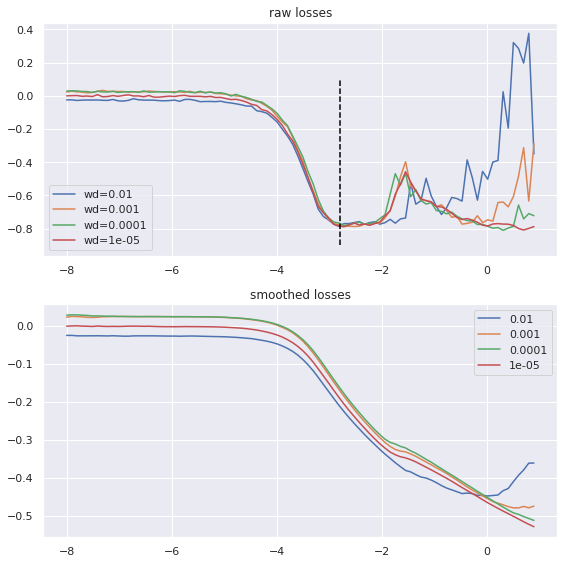

In [22]:
figsize(8, 8)
plot_find_lr(res1, -2.8)

#### Comb 2

In [23]:
print('Find LR for Comb 2...')
res2 = find_lr_for_one_comb(c2)

Find LR for Comb 2...
weight decay: 0.01
learning rate w/ steepest gradient 0.7033

weight decay: 0.001
learning rate w/ steepest gradient 0.6044

weight decay: 0.0001
learning rate w/ steepest gradient -3.3516

weight decay: 1e-05
learning rate w/ steepest gradient -3.3516



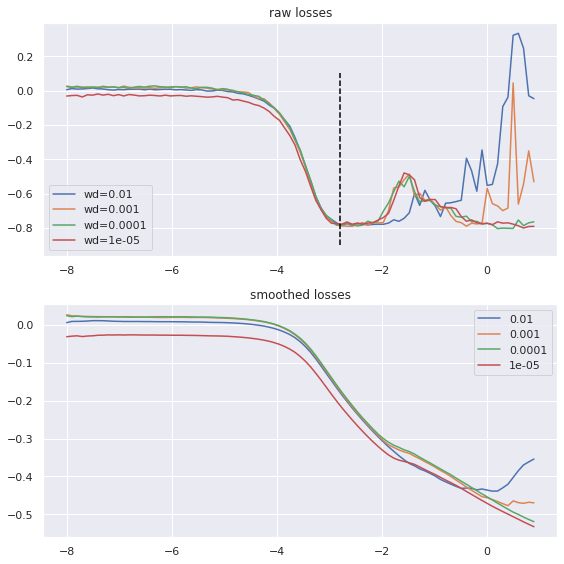

In [24]:
figsize(8, 8)
plot_find_lr(res2, -2.8)

#### Comb 3

In [25]:
print('Find LR for Comb 3...')
res3 = find_lr_for_one_comb(c3)

Find LR for Comb 3...
weight decay: 0.01
learning rate w/ steepest gradient 0.9063

weight decay: 0.001
learning rate w/ steepest gradient -3.3125

weight decay: 0.0001
learning rate w/ steepest gradient 0.7188

weight decay: 1e-05
learning rate w/ steepest gradient -3.4062



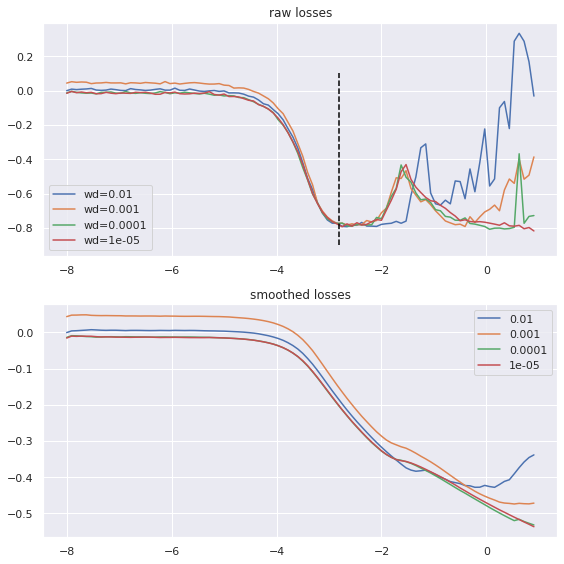

In [26]:
figsize(8, 8)
plot_find_lr(res3, -2.8)

### Train

In [27]:
def train_model(train_loader, model, optimizer, scheduler):
    
    model.train()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    lrs = []
    
    for i, (x, y) in enumerate(train_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
        
        total += batch
        sum_corr += batch * corr
    
    train_corr = sum_corr/total 
    return train_corr, lrs

In [28]:
def model_eval(model, val_loader):
    model.eval()
    sum_corr = 0.0 # sum_loss = 0.0
    total = 0
    
    for i, (x, y) in enumerate(val_loader):
        batch = x.shape[0]
        
        preds = model(x)
        vpreds = preds - torch.mean(preds)
        vy = y - torch.mean(y)
        corr = torch.sum(vpreds * vy) / \
               (torch.sqrt(torch.sum(vpreds ** 2)) *
                torch.sqrt(torch.sum(vy ** 2)))
        loss = -corr
        
        total += batch
        sum_corr += batch * corr
        
    val_corr = sum_corr/total
    return val_corr

In [29]:
def train_one_comb(c, max_lr, weight_decay, epochs,
                   folds=folds):
    # Set up dataloader
    train_loader, val_loader = set_up_dataloader(c, folds=folds)
    
    # Set up model
    net = Net()

    # Set up optimizer & scheduler
    optimizer = optim.Adam(net.parameters(),
                           weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler\
                     .OneCycleLR(optimizer, 
                                 max_lr=max_lr,
                                 steps_per_epoch=len(train_loader),
                                 epochs=epochs)
    
    # Train
    train_corrs = []
    val_corrs = []
    num_epochs_run = 0
    lrs = []

    for epoch in range(epochs):
        num_epochs_run += 1

        # train
        print('epoch', epoch)
        train_corr, epoch_lrs = train_model(train_loader, net, optimizer, scheduler)
        train_corr = float(train_corr.detach().numpy())
        train_corrs.append(train_corr)
        lrs.append(epoch_lrs)
        print(f'train corr: {train_corr:.4f}')

        # val
        val_corr = model_eval(net, val_loader)
        val_corr = float(val_corr.detach().numpy())
        val_corrs.append(val_corr)
        print(f'val corr: {val_corr:.4f}')
        print()
        
    return net, lrs

In [30]:
net1, lrs1 = train_one_comb(c1, 
                            max_lr=0.002, 
                            weight_decay=0.001, 
                            epochs=20)

epoch 0
train corr: 0.6501
val corr: 0.8103

epoch 1
train corr: 0.8605
val corr: 0.8550

epoch 2
train corr: 0.8762
val corr: 0.8630

epoch 3
train corr: 0.8784
val corr: 0.8657

epoch 4
train corr: 0.8778
val corr: 0.8651

epoch 5
train corr: 0.8773
val corr: 0.8671

epoch 6
train corr: 0.8782
val corr: 0.8663

epoch 7
train corr: 0.8792
val corr: 0.8676

epoch 8
train corr: 0.8803
val corr: 0.8704

epoch 9
train corr: 0.8812
val corr: 0.8698

epoch 10
train corr: 0.8826
val corr: 0.8710

epoch 11
train corr: 0.8838
val corr: 0.8724

epoch 12
train corr: 0.8851
val corr: 0.8740

epoch 13
train corr: 0.8869
val corr: 0.8750

epoch 14
train corr: 0.8888
val corr: 0.8784

epoch 15
train corr: 0.8903
val corr: 0.8793

epoch 16
train corr: 0.8921
val corr: 0.8796

epoch 17
train corr: 0.8938
val corr: 0.8807

epoch 18
train corr: 0.8954
val corr: 0.8810

epoch 19
train corr: 0.8962
val corr: 0.8812



In [31]:
net2, lrs2 = train_one_comb(c2, 
                            max_lr=0.002, 
                            weight_decay=0.001, 
                            epochs=20)

epoch 0
train corr: 0.6483
val corr: 0.7984

epoch 1
train corr: 0.8608
val corr: 0.8457

epoch 2
train corr: 0.8769
val corr: 0.8591

epoch 3
train corr: 0.8791
val corr: 0.8581

epoch 4
train corr: 0.8790
val corr: 0.8573

epoch 5
train corr: 0.8790
val corr: 0.8580

epoch 6
train corr: 0.8803
val corr: 0.8572

epoch 7
train corr: 0.8809
val corr: 0.8642

epoch 8
train corr: 0.8820
val corr: 0.8658

epoch 9
train corr: 0.8827
val corr: 0.8666

epoch 10
train corr: 0.8846
val corr: 0.8685

epoch 11
train corr: 0.8857
val corr: 0.8693

epoch 12
train corr: 0.8873
val corr: 0.8701

epoch 13
train corr: 0.8888
val corr: 0.8727

epoch 14
train corr: 0.8905
val corr: 0.8719

epoch 15
train corr: 0.8921
val corr: 0.8758

epoch 16
train corr: 0.8940
val corr: 0.8755

epoch 17
train corr: 0.8956
val corr: 0.8766

epoch 18
train corr: 0.8971
val corr: 0.8777

epoch 19
train corr: 0.8979
val corr: 0.8776



In [32]:
net3, lrs3 = train_one_comb(c3, 
                            max_lr=0.002, 
                            weight_decay=0.001, 
                            epochs=20)

epoch 0
train corr: 0.6599
val corr: 0.8038

epoch 1
train corr: 0.8601
val corr: 0.8508

epoch 2
train corr: 0.8759
val corr: 0.8644

epoch 3
train corr: 0.8770
val corr: 0.8623

epoch 4
train corr: 0.8775
val corr: 0.8626

epoch 5
train corr: 0.8767
val corr: 0.8672

epoch 6
train corr: 0.8775
val corr: 0.8665

epoch 7
train corr: 0.8781
val corr: 0.8688

epoch 8
train corr: 0.8796
val corr: 0.8695

epoch 9
train corr: 0.8806
val corr: 0.8694

epoch 10
train corr: 0.8817
val corr: 0.8711

epoch 11
train corr: 0.8831
val corr: 0.8734

epoch 12
train corr: 0.8848
val corr: 0.8747

epoch 13
train corr: 0.8861
val corr: 0.8756

epoch 14
train corr: 0.8877
val corr: 0.8767

epoch 15
train corr: 0.8891
val corr: 0.8788

epoch 16
train corr: 0.8909
val corr: 0.8793

epoch 17
train corr: 0.8924
val corr: 0.8796

epoch 18
train corr: 0.8936
val corr: 0.8803

epoch 19
train corr: 0.8943
val corr: 0.8800



## Find Out CV Score

In [33]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    It is assumed that the predictions are not constant.
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [34]:
%%time
DATA_DIR = '../input/msci-citeseq-mlp-tsvd'
train_inp = load_pickle(f'{DATA_DIR}/train_inp')[:, :-1]
train_inp = torch.from_numpy(train_inp)

CPU times: user 64.4 ms, sys: 291 ms, total: 355 ms
Wall time: 356 ms


In [35]:
%%time
with torch.no_grad():
    net1.eval()
    train_preds1 = net1(train_inp).detach().numpy()
    
    net2.eval()
    train_preds2 = net2(train_inp).detach().numpy()
    
    net3.eval()
    train_preds3 = net3(train_inp).detach().numpy()

CPU times: user 7.04 s, sys: 870 ms, total: 7.91 s
Wall time: 3.96 s


In [36]:
train_tar_preds = (train_preds1 + train_preds2 + train_preds3) / 3
train_tar_preds.shape

(70988, 140)

In [37]:
correlation_score(train_tar, train_tar_preds)

0.8992210276820716

In [38]:
del train_inp, train_tar, train_tar_preds
gc.collect()

169

## Prediction

In [39]:
%%time
DATA_DIR = '../input/msci-citeseq-mlp-tsvd'
test_inp = load_pickle(f'{DATA_DIR}/test_inp')[:, :-1]
test_inp = torch.from_numpy(test_inp)

CPU times: user 52.1 ms, sys: 189 ms, total: 241 ms
Wall time: 1.62 s


In [40]:
%%time
with torch.no_grad():
    net1.eval()
    test_preds1 = net1(test_inp).detach().numpy()
    
    net2.eval()
    test_preds2 = net2(test_inp).detach().numpy()
    
    net3.eval()
    test_preds3 = net3(test_inp).detach().numpy()

CPU times: user 4.87 s, sys: 564 ms, total: 5.43 s
Wall time: 2.72 s


In [41]:
test_tar_preds = (test_preds1 + test_preds2 + test_preds3) / 3
test_tar_preds.shape

(48663, 140)

In [42]:
del test_inp
gc.collect()

84

## Creating Submission

In [43]:
DATA_DIR = '../input/msci-h5-sparse-transform'
%ls $DATA_DIR -lh

total 7.1G
-rw-r--r-- 1 nobody nogroup  25K Nov 14 16:09 __notebook__.ipynb
-rw-r--r-- 1 nobody nogroup  25K Nov 14 16:09 __output__.json
-rw-r--r-- 1 nobody nogroup 293K Nov 14 16:09 __results__.html
-rw-r--r-- 1 nobody nogroup    0 Nov 14 16:09 custom.css
-rw-r--r-- 1 nobody nogroup 359M Nov 14 16:09 evaluation_ids.parquet
-rw-r--r-- 1 nobody nogroup 3.8M Nov 14 16:09 metadata.parquet
-rw-r--r-- 1 nobody nogroup 108K Nov 14 16:09 metadata_cite_day_2_donor_27678.parquet
-rw-r--r-- 1 nobody nogroup 252M Nov 14 16:09 sample_submission.parquet
-rw-r--r-- 1 nobody nogroup 856K Nov 14 16:09 test_cite_inputs_day_2_donor_27678_idx.npz
-rw-r--r-- 1 nobody nogroup  78M Nov 14 16:09 test_cite_inputs_day_2_donor_27678_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 1.8M Nov 14 16:09 test_cite_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 488M Nov 14 16:09 test_cite_inputs_val.sparse.npz
-rw-r--r-- 1 nobody nogroup 8.4M Nov 14 16:09 test_multi_inputs_idx.npz
-rw-r--r-- 1 nobody nogroup 1.7G Nov 14 16:10 

In [44]:
test_tar_cols = np.load(f'{DATA_DIR}/train_cite_targets_idx.npz',
                        allow_pickle=True)['columns']
test_tar_idx = np.load(f'{DATA_DIR}/test_cite_inputs_idx.npz',
                       allow_pickle=True)['index']
test_tar_cols.shape, test_tar_idx.shape, test_tar_preds.shape

((140,), (48663,), (48663, 140))

In [45]:
%%time
print('Start Eval...')
eval_ids = pd.read_parquet(f'{DATA_DIR}/evaluation_ids.parquet')
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())

Start Eval...
CPU times: user 28.8 s, sys: 9.87 s, total: 38.7 s
Wall time: 34 s


In [46]:
%%time
sub = pd.Series(name='target',
                index=pd.MultiIndex.from_frame(eval_ids), 
                dtype=np.float32)
sub

CPU times: user 19.1 s, sys: 3.51 s, total: 22.6 s
Wall time: 22.6 s


row_id    cell_id       gene_id        
0         c2150f55becb  CD86              NaN
1         c2150f55becb  CD274             NaN
2         c2150f55becb  CD270             NaN
3         c2150f55becb  CD155             NaN
4         c2150f55becb  CD112             NaN
                                           ..
65744175  2c53aa67933d  ENSG00000134419   NaN
65744176  2c53aa67933d  ENSG00000186862   NaN
65744177  2c53aa67933d  ENSG00000170959   NaN
65744178  2c53aa67933d  ENSG00000107874   NaN
65744179  2c53aa67933d  ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

In [47]:
cell_id_dict = {cell_id: idx 
                for idx, cell_id in enumerate(test_tar_idx, 0)}
gene_id_dict = {gene_id: idx 
                for idx, gene_id in enumerate(test_tar_cols, 0)}

In [48]:
eid_cid_idx = eval_ids['cell_id']\
              .apply(lambda x: cell_id_dict.get(x, -1))
eid_gid_idx = eval_ids['gene_id']\
              .apply(lambda x: gene_id_dict.get(x, -1))
valid_cite_rows = (eid_cid_idx != -1) & (eid_gid_idx != -1)

In [49]:
%%time
sub.iloc[valid_cite_rows] = test_tar_preds\
                             [eid_cid_idx[valid_cite_rows].to_numpy(),
                              eid_gid_idx[valid_cite_rows].to_numpy()]

CPU times: user 275 ms, sys: 168 ms, total: 443 ms
Wall time: 443 ms


In [50]:
del eval_ids, test_tar_idx, test_tar_cols
del eid_cid_idx, eid_gid_idx, valid_cite_rows
gc.collect() 

97

In [51]:
sub = pd.DataFrame(sub).fillna(0).reset_index()
sub.drop(['cell_id', 'gene_id'], axis=1)\
   .to_csv('cite_sub.csv', index=False)

In [52]:
sub.head()

,row_id,cell_id,gene_id,target
0,0,c2150f55becb,CD86,-0.021298
1,1,c2150f55becb,CD274,-0.021433
2,2,c2150f55becb,CD270,-0.019008
3,3,c2150f55becb,CD155,0.009059
4,4,c2150f55becb,CD112,0.013141
